In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from LAB_UW_functions import *
from scipy.signal import find_peaks
import os
import glob
import json

In [2]:

def find_mechanical_data(file_path_list, pattern):
    """
    Trova un file specifico all'interno di una lista di percorsi dei file utilizzando un pattern.
    
    Args:
        file_path_list (list): Lista di percorsi dei file in cui cercare il file.
        pattern (str): Pattern per il nome del file da cercare.
    
    Returns:
        str: Percorso completo del file trovato, o None se non viene trovato nessun file corrispondente.
    """
    for file_path in file_path_list:
        if glob.fnmatch.fnmatch(file_path, pattern):
            print("MECHANICAL DATA CHOOSE:", file_path)
            return file_path
    return None  # Nessun file trovato nella lista
    

def find_sync_values(mech_data_path):
    """
    Trova i valori di picco sincronizzazione all'interno di un file di dati meccanici.

    Questa funzione legge un file CSV contenente dati meccanici, estrae la colonna
    relativa alla sincronizzazione e individua i picchi di sincronizzazione in base
    ai parametri specificati.

    Args:
        mech_data_path (str): Percorso del file CSV contenente i dati meccanici.

    Returns:
        numpy.ndarray: Un array NumPy contenente gli indici dei picchi di sincronizzazione
                       trovati nei dati meccanici.
    """
    mech_data = pd.read_csv(mech_data_path, sep='\t', skiprows=[1])
    sync_data = mech_data.sync
    
    # Trova i picchi di sincronizzazione nei dati sincronizzazione
    sync_peaks, _ = find_peaks(sync_data, prominence=0.5, height=0.5)
    print(sync_peaks)
    return mech_data, sync_data, sync_peaks

def plot_sync_peaks(sync_data, sync_peaks, experiment_name):
    """
    Visualizza i picchi di sincronizzazione su un grafico dei dati di sincronizzazione.

    Questa funzione prende i dati di sincronizzazione e gli indici dei picchi di sincronizzazione,
    quindi crea un grafico per visualizzare sia i dati di sincronizzazione che i picchi di sincronizzazione
    evidenziati in rosso.

    Args:
        sync_data (numpy.ndarray): Array NumPy contenente i dati di sincronizzazione.
        sync_peaks (numpy.ndarray): Array NumPy contenente gli indici dei picchi di sincronizzazione.
        experiment_name (str): Nome dell'esperimento o della prova da visualizzare nel titolo del grafico.
    """
    %matplotlib inline
    
    plt.figure(figsize=(10, 4))
    plt.title(f'Sync Peaks {experiment_name}')
    

    # Plot dei picchi di sincronizzazione evidenziati in rosso
    plt.scatter(np.arange(0, len(sync_data))[sync_peaks], sync_data[sync_peaks], c='r', s = 10, zorder = 2, alpha = 0.8)
    
    # Plot dei dati di sincronizzazione
    plt.plot(sync_data, zorder = 1, c = 'k', linewidth = 0.8)
    
    plt.ylabel('Arduino voltage [V]', fontsize=12)
    plt.xlabel('records #', fontsize=12)
    
    plt.show()
    

def save_sync_values(machine_name, experiment_name, data_type, sync_peaks):
    """
    Save synchronization peak values into a text file.

    This function takes synchronization peak values and saves them into a text file
    specified in the experiments directory.

    Args:
        machine_name (str): Name of the machine or device.
        experiment_name (str): Name of the experiment or trial.
        data_type (str): Type of data (e.g., "mechanical_data").
        sync_peaks (numpy.ndarray): NumPy array containing the indices of synchronization peaks.
    """
    code_path = os.getcwd()
    parent_folder = os.path.abspath(os.path.join(code_path, os.pardir))
    outdir_path = os.path.join(parent_folder, "experiments_" + machine_name, experiment_name, data_type)
    outfile_name = 'sync_peaks.txt'
    outfile_path = os.path.join(outdir_path, outfile_name)
    
    # Save synchronization peak values into the text file
    np.savetxt(outfile_path, sync_peaks)
    
    # Print a confirmation message
    print(f'Saving synchronization peaks of {experiment_name} at: {outfile_path}')
    
def extract_layer_thickness(sync_peaks, mech_data, infile_path_list_uw):
    for sync_rec, uw_path in zip(range (0, len(sync_peaks), 2), infile_path_list_uw):
        gouge_1_lt = mech_data.rgt_lt_mm[sync_peaks[sync_rec]:sync_peaks[sync_rec+1]]
        gouge_2_lt = mech_data.rgt_lt_mm[sync_peaks[sync_rec]:sync_peaks[sync_rec+1]]
    
    return gouge_1_lt, gouge_2_lt

def load_waveform_json(infile_path):
    '''
    # given an infile path, load data and metadata that have been serialized to be stored in a json file
    # such file could be the basis of all our data analysis files
    '''
    with open(infile_path, "r") as json_file:
        data_dict = json.load(json_file)

    # Retrieve metadata and data from the loaded dictionary
    data = np.array(data_dict["data"])
    metadata = data_dict["metadata"]

    return data,metadata

def compute_max_and_min_travel_time(side_block_1, x_transmitter, c_steel, gouge_1, c_min, c_max, central_block):
    """
    Compute the maximum and minimum travel times for a signal transmitted through the sample assembly (DDS).

    Parameters:
        side_block_1 (float): Thickness of the side blocks used in the DDS configuration in [cm]
        x_transmitter (float): thickness of the trasnmitter PZT [cm]
        c_steel (float): Speed of wave propagation in steel (units: distance per time).
        gouge_1 (float): The thickness of the gouge layer.
        c_min (float): Minimum speed of signal propagation in the gouge layer.
        c_max (float): Maximum speed of signal propagation in the gouge layer.
        central_block (float): The thickness of the central block.

    Returns:
        tuple: A tuple containing the maximum and minimum travel times.

    The function computes the maximum and minimum travel times for a signal transmitted through
    a DDS configurations (2 side blocks, 1 central block, 2 gouge layers), where the signal
    travels from a transmitter located within the side block to a receiver located in the other.
    The travel times are calculated based on the given parameters such as
    distances, material properties, and signal propagation speeds.

    The maximum travel time is calculated considering the minimum speed of propagation in the gouge layer,
    while the minimum travel time is calculated considering the maximum speed of propagation in the gouge layer.
    """

    # Compute the maximum travel time
    max_travel_time = 2 * (side_block_1 - x_transmitter) / c_steel + 2 * gouge_1 / c_min + central_block / c_steel
    # Compute the minimum travel time
    min_travel_time = 2 * (side_block_1 - x_transmitter) / c_steel + 2 * gouge_1 / c_max + central_block / c_steel

    return max_travel_time, min_travel_time


def compute_observed_pulse_interval(sync_peaks, max_travel_time, t_OBS, min_travel_time, time_span, data_OBS, uw_file_number, plot=False):
    """
    Compute the observed pulse interval based on synchronization peaks and travel time intervals.

    Parameters:
        sync_peaks (array-like): An array containing synchronization peak indices.
        max_travel_time (array-like): An array containing maximum travel times for each peak.
        t_OBS (array-like): An array containing observed wf time [microseconds].
        min_travel_time (array-like): An array containing minimum travel times for each peak.
        time_span (float): Time span.
        data_OBS (array-like): An array containing observed waveforms.
        plot (bool, optional): If True, plot the observed pulse window. Defaults to False.

    Returns:
        tuple: A tuple containing indices corresponding to the observed pulse interval.

    This function computes the observed pulse interval based on synchronization peaks and travel time intervals.
    It calculates the real index of the experiment based on the initial index and synchronizes it with the observation time.
    Then, it computes the pulse window within the specified time span.
    The function returns indices corresponding to the observed pulse interval.
    """

    initial_index = sync_peaks[uw_file_number]  # the initial index is not 0, but the first value of rec# of layer thickness array (from mech data)
    for idx in range(0, len(max_travel_time)):
        exp_index = idx + initial_index  # calculate real index of the experiment
        interval = np.where((t_OBS > min_travel_time[exp_index]) & (t_OBS < max_travel_time[exp_index] + time_span))  # calculate the pulse window

    if plot:
        %matplotlib inline
        f = plt.figure(figsize=(8, 6))
        plt.title('Observed Pulse Window')
        plt.plot(t_OBS[interval], data_OBS[2][interval], c='g')
        plt.xlabel('Wf_time [$\mu s$]')
        plt.ylabel('Relative amplitude [a.u.]')
        plt.show()
        
        f2 = plt.figure(figsize=(8, 6))
        plt.plot(t_OBS, data_OBS[2], c='k')
        plt.plot(t_OBS[interval], data_OBS[2][interval], c='r')
        plt.xlabel('Wf_time [$\mu s$]')
        plt.ylabel('Relative amplitude [a.u.]')
        plt.show()

    return interval



MECHANICAL DATA CHOOSE: c:\Users\miche\Documents\Università\PhD\ACTIVE_SOURCE\experiments_Brava_2\s0112\mechanical_data\s0112sa05ato_204060_data_rp
[  6148   7848   9297  22904  27503  40128  51238 114608 122192 123707
 125435 139123 143745 156318 168122 227608 232676 234123 235982 237682
 239423 253077 257696 270171 290158 362818]


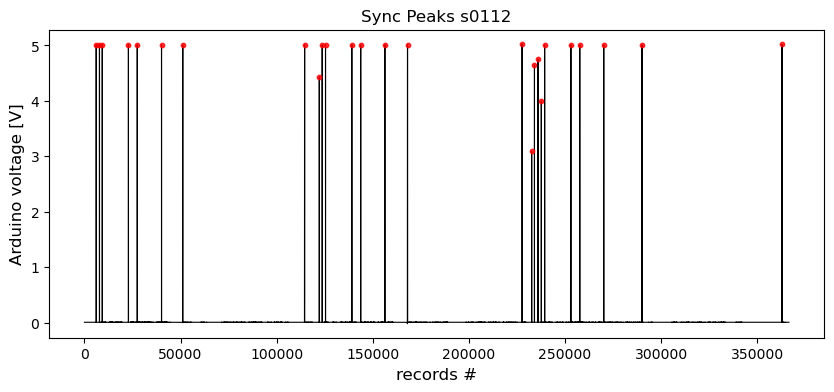

In [3]:
machine_name = 'Brava_2'
experiment_name = 's0112'
data_type_mech = 'mechanical_data'
sync_file_pattern = '*s*_data_rp' #pattern to find specific experiment in mechanical data
uw_file_number = 6    #choose number of eaveform file


data_type_uw = 'data_tsv_files'
remove_initial_samples = 50

#MAKE MECHANICAL AND UW PATH LIST
infile_path_list_mech = make_infile_path_list(machine_name, experiment_name, data_type=data_type_mech)
infile_path_list_uw = sorted(make_infile_path_list(machine_name,experiment_name, data_type=data_type_uw))

#LOAD MECHANICAL DATA
mech_data_path= find_mechanical_data(infile_path_list_mech, sync_file_pattern)
    
mech_data, sync_data, sync_peaks = find_sync_values(mech_data_path)
plot_sync_peaks(sync_data, sync_peaks, experiment_name)

In [4]:
# LOAD OBSERVED WAVEFORM DATA
waveform_file_path = infile_path_list_uw[uw_file_number]  #choose one waveform in infile path list 
print('PROCESSING UW DATA IN %s: ' %waveform_file_path)
data_OBS,metadata = make_UW_data(waveform_file_path)
t_OBS = metadata['time_ax_waveform']

PROCESSING UW DATA IN c:\Users\miche\Documents\Università\PhD\ACTIVE_SOURCE\experiments_Brava_2\s0112\data_tsv_files\008_step_3_100_3_40MPa.bscan.tsv: 


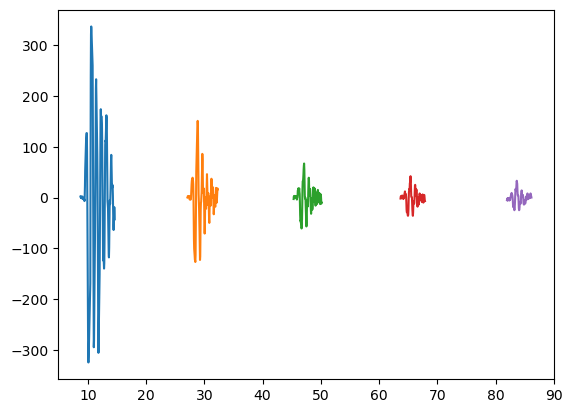

In [5]:
### INPUT DATA ###

side_block_1 = 2               # [cm] width of first side block
side_block_2 = 2               # [cm] width of first gouge layer
central_block = 4.8
#gouge_1, gouge_2 = gouge_layer_thickness(mech_data, sync_peaks)
gouge_1 = mech_data.rgt_lt_mm[sync_peaks[uw_file_number*2]:sync_peaks[uw_file_number*2+1]]/10

sample_dimensions = [side_block_1,gouge_1,central_block,gouge_1,side_block_2]  # [cm] total length of the sample

# TRASMISSION AT 0 ANGLE: ONE RECEIVER, ONE TRASMITTER
x_trasmitter = 0.95                              # [cm] position of the trasmitter from the beginning of the sample
x_receiver = sum(sample_dimensions) -0.95        # [cm] position of the receiver from the end of the sample
pzt_width = 0.1                                  # [cm] its important!
pmma_width = 0.1                                 # [cm] plate supporting the pzt

# GUESSED VELOCITY MODEL OF THE SAMPLE
csteel = 3250 * (1e2/1e6)      # [cm/mus]   steel s-velocity
# cair = 330 * (1e2/1e6)       # [cm/mus]   around air p-velocity. Could S-velocity in granular media be less then that?
                             # https://www.sciencedirect.com/science/article/pii/S0041624X15003042
                             # It seems so, but let play easy for now.

cmin = 1000 * (1e2/1e6)
cmax = 2000 * (1e2/1e6) #get from literature


# Load the pulse waveform: it is going to be our time source function
machine_name_pulse = "on_bench"
experiment_name = "glued_pzt"
data_type = "data_analysis/pulses_from_glued_pzt"
infile_path_list_pulse  = make_infile_path_list(machine_name=machine_name_pulse,experiment_name=experiment_name,data_type=data_type)

pulse_list = []
pulse_metadata_list = []
t_pulse_list = []
time_span = []
for pulse_path in sorted(infile_path_list_pulse): 
    pulse, pulse_metadata = load_waveform_json(pulse_path)
    t_pulse = pulse_metadata['time_ax_waveform']
    time_span.append(np.ptp(t_pulse))
    pulse_list.append(pulse)
    pulse_metadata_list.append(pulse_metadata)
    t_pulse_list.append(t_pulse)
    plt.plot(t_pulse, pulse)

time_span = min(time_span)


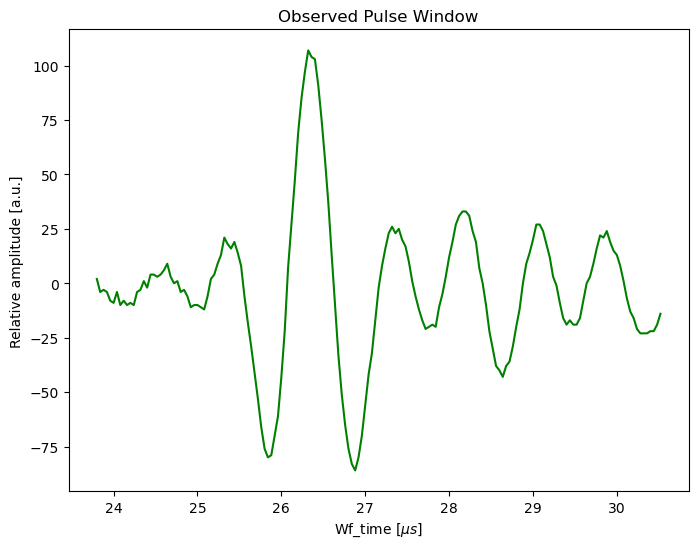

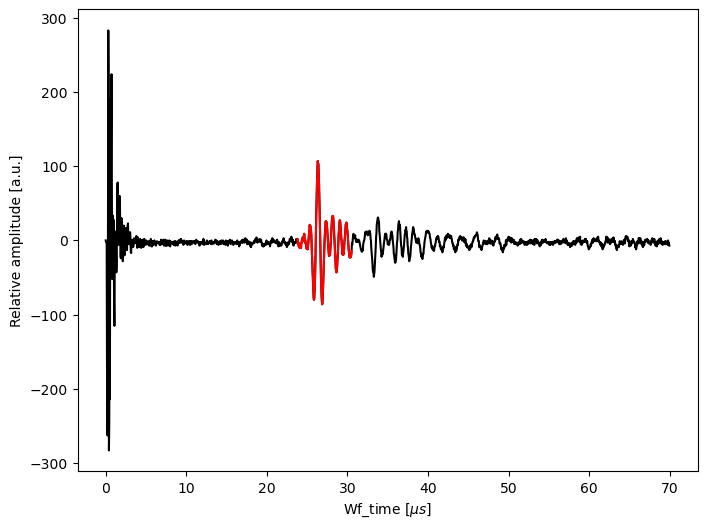

In [6]:
max_travel_time, min_travel_time = compute_max_and_min_travel_time(side_block_1, x_trasmitter, csteel, gouge_1, cmin, cmax, central_block)
interval = compute_observed_pulse_interval(sync_peaks, max_travel_time, t_OBS, min_travel_time, time_span, data_OBS, uw_file_number*2, plot = True)

In [7]:
%matplotlib qt

time = mech_data.time_s[sync_peaks[uw_file_number*2]:sync_peaks[uw_file_number*2+1]]
time = time - time[sync_peaks[uw_file_number*2]]

In [8]:
#for sync_rec, uw_path in zip(range (0, len(sync_peaks), 2), infile_path_list_uw):
#    friction = mech_data.friction_na[sync_peaks[sync_rec]:sync_peaks[sync_rec+1]]
#    time = mech_data.time_s[sync_peaks[sync_rec]:sync_peaks[sync_rec+1]]
#    time = time - time[sync_peaks[sync_rec]]
#    displacement = mech_data.lp_disp_mm[sync_peaks[sync_rec]:sync_peaks[sync_rec+1]]    


## Detrend layer thickness ##

In this part of the code you can semi-authomatically detrend the layer thickness of your velocity steps to eliminate the effect of the advanncing LVDT during the experiment, to clearly see dilation and compaction of the gouge 

In [20]:
%matplotlib qt
        
def onclick(event):
    # Controlla se il clic è un doppio clic del mouse sinistro
    if event.dblclick:
        # Ottieni l'indice più vicino sull'asse x
        print ('row #=%d'%(event.xdata))
        event.xdata = int(event.xdata)
        pick_row.append('\n %d %d %.4f' %(event.button,event.xdata,event.ydata))
         
        x.append(event.xdata); y.append(event.ydata)
        
row_n = np.arange(0,len(mech_data['rgt_lt_mm']),1)
pick_row = []; x=[]; y=[]

fig=plt.figure(figsize=(12,8))
plt.subplots_adjust(hspace=(0.1))
ax1=plt.subplot(111)
ax1.plot(row_n,mech_data['friction_na'],color='k',marker='o',markersize=3)
ax1.set_ylabel('Friction ($\mu$)')
ax1.set_xlabel('Row #')
cid = fig.canvas.mpl_connect('button_press_event', onclick)

row #=149746
row #=150287


In [21]:
row_s = 149746
row_e = 150287

In [22]:
# slice the interval in the data
layer_thickness = mech_data['rgt_lt_mm'][row_s:row_e]
#layer_thickness = layer_thickness.reshape(len(layer_thickness))
disp = mech_data['ec_disp_mm'][row_s:row_e]
#disp = disp.reshape(len(disp))
friction = mech_data['friction_na'][row_s:row_e]
#friction = friction.reshape(len(friction))

In [12]:
# pick the row for the fitting used to detrend 

fig=plt.figure()
ax1=plt.subplot(111)
ax1.plot(layer_thickness,'r')
ax1.set_ylabel('Layer Thickness [mm]',color='r')
ax2=ax1.twinx()
ax2.plot(friction,'k',alpha=0.5)
ax2.set_ylabel('Friction')
ax1.set_xlabel('row #')
fig.tight_layout()
#cursor = FollowDotCursor(ax2,row_n,data['rgt'])
cid = fig.canvas.mpl_connect('button_press_event', onclick)

row #=149952
row #=150267


In [13]:
row_fs = int(input('first row: '))
row_fe = int(input('last row: '))

In [23]:

model_s1 = np.polyfit(disp.loc[row_fs:row_fe],layer_thickness.loc[row_fs:row_fe],1)
predicted_s1 = np.polyval(model_s1, disp)
detrend_s1 = layer_thickness-predicted_s1
detrend_s1 = detrend_s1-detrend_s1[row_fs]
detrend_s1 = detrend_s1 - detrend_s1.iloc[0]
layer_thickness_dtr = np.average(detrend_s1.loc[row_fs:row_fe])

#layer_thickness_dtr = np.max(detrend_s1)


fig=plt.figure(99,figsize=(8,8))

ax1=plt.subplot(211)
ax1.plot(disp,layer_thickness)
ax1.plot(disp.loc[row_fs:row_fe],layer_thickness.loc[row_fs:row_fe],'r')
ax1.plot(disp,predicted_s1,'k--')
ax1.set_ylabel('Layer thickness (mm)')
#ax1.set_title(r'%s [$\mu$m/s]'%v_int)
ax2=plt.subplot(212)
ax2.plot(disp,detrend_s1,'b')
ax2.axhline(layer_thickness_dtr,color='r',linestyle='--')
ax2.axhline(np.max(detrend_s1),color='g',linestyle='--')
ax2.set_ylabel(r'Detrend LT (mm)')
ax3=ax2.twinx()
ax3.plot(disp,friction,'k',alpha=0.5)
ax3.set_ylabel('Friction')
ax2.set_xlabel('Displacement')

print( r'average dilation: %s [micron]'%layer_thickness_dtr)
print('Maximum dilation %s'%(np.max(detrend_s1)))

average dilation: 0.0021064081581709847 [micron]
Maximum dilation 0.0027228188938073217


In [278]:
# Inizializza una griglia di assi
fig, axs = plt.subplots(1, 1, figsize=(10, 4))

# Inizializza una lista vuota per salvare i valori di ptp
labels = []
norm = mcolors.Normalize(vmin=0, vmax=len(data_OBS))

for wave in range(0, len(data_OBS), 50):
    massimo = np.max(data_OBS[wave][627:648])
    minimo = np.min(data_OBS[wave][627:648])
    #ptp.append(massimo - minimo)
    plot_max = axs.scatter(np.argmax(data_OBS[wave][627:648]), massimo, c=wave, cmap='viridis', norm=norm, zorder=2, label='Massimo')
    plot_min = axs.scatter(np.argmin(data_OBS[wave][627:648]), minimo, c=wave, cmap='viridis', norm=norm, zorder=2, label='Minimo')
    if wave == 0:
        labels.extend([plot_max, plot_min])
axs.plot(data_OBS[1000][interval], c='k', alpha=0.5, zorder=1)
#axs.plot(data_OBS[5000][interval], c='r', alpha=0.5, zorder=1)
#axs.plot(data_OBS[10000][interval], c='b', alpha=0.5, zorder=1)


cbar = plt.colorbar(plot_max, ax=axs)
cbar.set_label('Tempo')

In [296]:
plt.plot(data_OBS[1000])

In [16]:
%matplotlib qt

# Inizializza una griglia di assi
fig, axs = plt.subplots(1, 1, figsize=(16, 7))

# Inizializza una lista vuota per salvare i valori di ptp
ptp = []

for wave in range(0, len(data_OBS), 1):
    massimo = np.max(data_OBS[wave][642:670])
    minimo = np.min(data_OBS[wave][642:670])
    ptp.append(massimo-minimo)

# Converti ptp in un array numpy
ptp = np.array(ptp)

#transmissivity = ptp/layer_thickness

# Crea un array di tempi per ptp con la stessa lunghezza di mech_data.friction_na
time_interp = np.linspace(0, len(mech_data.friction_na[sync_peaks[uw_file_number*2]:sync_peaks[uw_file_number*2+1]]), len(ptp))

# Plotta mech_data.friction_na nel primo subplot
axs.plot(time, mech_data.friction_na[sync_peaks[uw_file_number*2]:sync_peaks[uw_file_number*2+1]], c='k', linewidth=1, alpha=0.9, label='Friction curve')
#axs.set_ylim(0.4,0.6)


# Aggiungi un secondo asse y per il subplot inferiore
axs1_sec = axs.twinx()
axs2_sec = axs.twinx()

axs2_sec.spines['right'].set_position(('outward', 60))
axs2_sec.set_ylabel('$\Delta h$', fontsize=14)

axs2_sec.spines['right'].set_color('cornflowerblue')
axs2_sec.tick_params(axis='y', colors='cornflowerblue')
axs2_sec.yaxis.label.set_color('cornflowerblue')
#axs2_sec.set_ylim(-0.0025,0.002)


# Interpola ptp per avere la stessa lunghezza di mech_data.friction_na
ptp_interp = np.interp(np.linspace(0, len(ptp), len(mech_data.friction_na[sync_peaks[uw_file_number*2]:sync_peaks[uw_file_number*2+1]])), np.arange(len(ptp)), ptp)
lt_interp = np.interp(np.linspace(0, len(detrend_s1), len(mech_data.friction_na[sync_peaks[uw_file_number*2]:sync_peaks[uw_file_number*2+1]])), np.arange(len(detrend_s1)), detrend_s1)
#transmissivity_interp = np.interp(np.linspace(0, len(transmissivity), len(mech_data.friction_na[sync_peaks[uw_file_number*2]:sync_peaks[uw_file_number*2+1]])), np.arange(len(transmissivity)), transmissivity)

# Plotta ptp sul secondo asse y
axs1_sec.plot(time, ptp_interp, c='firebrick', label='Peak-to-peak amplitude', linewidth = 0.8)
axs1_sec.set_ylabel('Peak-to-peak amplitude', fontsize=14)
axs1_sec.spines['right'].set_color('firebrick')
axs1_sec.tick_params(axis='y', colors='firebrick')
axs1_sec.yaxis.label.set_color('firebrick')

axs2_sec.plot(time, lt_interp, c='b', linewidth=0.9, alpha=0.5, label='$\Delta h$')
#axs2_sec.set_ylim(-0.02,0.004)

lines, labels = axs.get_legend_handles_labels()
lines2, labels2 = axs1_sec.get_legend_handles_labels()
lines3, labels3 = axs2_sec.get_legend_handles_labels()

axs.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fontsize = 16, frameon = False)


axs.set_xlabel('Displacement [mm]', fontsize=14)
axs.set_ylabel('Friction [$\mu$]', fontsize=14)

axs.set_title('Peak-to-Peak VS vstep', fontsize = 14)

plt.tight_layout()
plt.show()
